#  2. CUDA memory model

In this lecture, we will focus on the memory hierarchy in NVIDIA GPU CUDA-enabled cards. Memory access is often a significant part of GPU kernel execution time, so choosing the right type of memory for the task at hand plays a key role.

During these exercises, we will learn how to use the following types of CUDA memory and what their advantages and limitations are:

1. global memory,
2. shared memory,
3. constant memory.

In this and the following notebooks, we will use the tools, tests and benchmarks available in the `gpu_short_course` Python package, which can be found in the repository https://github.com/us4useu/ius-2021-gpu-short-course. Let's do all the necessary imports first:

In [ ]:
import math
import cupy as cp
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import gpu_short_course

## 2.1. One-dimensional convolution, global memory

### 2.1.1. The task: 1D convolution on CPU

In this and subsequent notebooks, we will focus on one-dimensional convolution. The convolution operator has very broad applications that also include signal and image processing, and signal filtering in particular.

**Input**: 

- $x$: input signal of length $m$, 
- $h$: impulse response of filter a vector of $n$ samples,

**Output**: $y$: output signal of length $m$

The following definition will be used during this course:

\begin{equation*}
y[i] = (x \ast h)[i] = \sum_{j=0}^{n-1} x[i+o-j]h[j] 
\end{equation*}

where:
- $x[k]$ is equal 0 for $k < 0$ (equivalent to convolution with zero-padding),
- $m \ge n$ (for the sake of simplicity), 
- $o$ is the initial offset of the convolution. During the course this will assume the following (which corresponds to the `mode='same'` in the [`numpy.convolve`](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html)):

\begin{equation*}
o = \left\lceil \frac{n}{2} \right\rceil-1
\end{equation*}

Example:

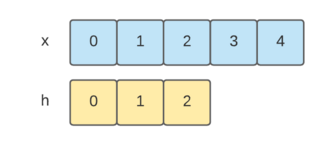

The convolution corresponds to moving the filter $h$ window as follows:

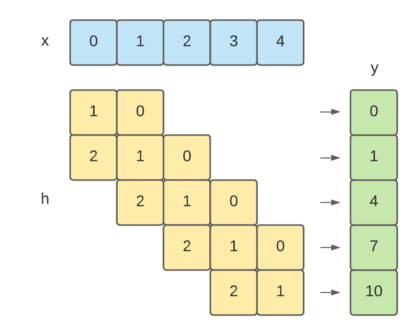

For given input parameters, input offset will be equal to `1`. So, the output signal will be equal to:
```
y[0] = h[0]*x[1]+h[1]*x[0]           = 0
y[1] = h[0]*x[2]+h[1]*x[1]*h[2]*x[0] = 1
y[2] = h[0]*x[3]+h[1]*x[2]*h[2]*x[1] = 4
y[3] = h[0]*x[4]+h[1]*x[3]+h[2]*x[2] = 7
y[4] = h[1]*x[4]+h[2]*x[3]           = 10
```


Let's implement a baseline version of the convolution, first on CPU. We can do it following directly the definition of the convolution.

**Exercise**

Fill in the missing line(s) of code, marked with the `# TODO` comment.

In [ ]:
def convolve_cpu(x, h):
    m = len(x)
    n = len(h)
    y = np.zeros(m, dtype=x.dtype)
    o = int(math.ceil(n/2)-1)
        
    # For each output sample.
    for i in range(m):
        value = 0.0
        # For each filter's coefficient.
        for j in range(n):
            # TODO
        y[i] = value
    return y


result = convolve_cpu(np.array([0, 1, 2, 3, 4]), 
                      np.array([0, 1, 2]))
np.testing.assert_equal(result, [0, 1, 4, 7, 10])
print(result)

Now let's check how the `convolve_cpu` function works in filtering less trivial signals. First, we will prepare an artificially noisy signal:

In [ ]:
t = np.linspace(-math.pi, math.pi, 200).astype(np.float32)
noisy_signal = np.sin(t) + 0.1*np.random.randn(len(t)).astype(np.float32)
plt.plot(t, noisy_signal)

We will use a [moving average filter](https://en.wikipedia.org/wiki/Moving_average) to remove the (artifically) added noise from the input signal. The moving average filter is simply a vector of $\frac{1}{N}$ values, where $N$ is the size of the filter. 

In [ ]:
n = 64
ma_filter = np.ones(n)/n
ma_filter = ma_filter.astype(np.float32)

Finally, let's do the actual filtering:

In [ ]:
denoised_signal = convolve_cpu(noisy_signal, ma_filter)
plt.plot(t, denoised_signal)

For the purpose of this course we have prepared two functions that check correctness and performance of the implemented functions: 
- `gpu_short_course.tests.test_convolve`: performs validation tests on the passed convolve function,
- `gpu_short_course.tests.benchmark_convolve`: measures the average execution time of the passed function on random data. 

Let's check if the function passes the tests prepared for this course:

In [ ]:
gpu_short_course.tests.test_convolve(convolve_cpu)

If everything is OK, you should see `All tests passed.`

Now, let's see how fast the CPU implementation is:


In [ ]:
gpu_short_course.tests.benchmark_convolve(convolve_cpu, x_size=2**15, n=1)

In [ ]:
gpu_short_course.tests.benchmark_convolve(lambda x, h: np.convolve(x, h, mode='same'), n=10)

As we have seen previously, `numpy` function is faster than its Python counterpart.

### 2.1.2. 1D convolution on GPU

Now, let's proceed with implementing 1D convolution on GPU.

We will follow the same approach as we did in Notebook 1: split the 1D convolution task into many smaller subtasks. 

Note that each output value $y[i]$ can be computed independently of the result $y[j]$ (for any $i, j < m$).

So, let's split the convolution into many smaller subtasks, where in each subtask we compute the value of $y[i]$, and assign each subtask to a separate CUDA thread.

**Exercise**

1. Open `2_1_convolve1d.cc` file.
2. Fill in the missing lines of code, marked with the `// TODO` comment.

In [ ]:
convolve_gpu_kernel_src = open("2_1_convolve1d.cc").read()
convolve_gpu_kernel = cp.RawKernel(code=convolve_gpu_kernel_src, name="convolve1d")

Let's wrap the above kernel and the thread hierarchy declaration into a complete function, which for a given `x` and `h` returns the result of the convolution:

In [ ]:
def convolve_gpu(x, h):
    y = cp.empty(shape=x.shape, dtype=np.float32)
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)


    block = 256
    grid = int(math.ceil(m/block))
    block = (block, )
    grid = (grid, )

    convolve_gpu_kernel(grid, block, args=(y, x, h, m, n, o))
    return y.get()

And verify that the above implementation works correctly:

In [ ]:
gpu_short_course.tests.test_convolve(convolve_gpu)

If everything is OK, you should see `All tests passed.` message.


Let's also inspect the result visually:

In [ ]:
denoised_signal = convolve_gpu(noisy_signal, ma_filter)
plt.plot(t, denoised_signal)

Now it's time to benchmark the GPU implementation:

In [ ]:
gpu_short_course.tests.benchmark_convolve(convolve_gpu, n=10)

The result will depend on the GPU device you have, but we think you should be able to notice some performance improvement :). 

The average processing time that you see above includes:
- the time required for memory allocations, data transfers from and to GPU device,
- the time required to execute the kernel code. 

Let's use the CUDA profiler to get a bit more detail about the time it takes to complete each step:

In [ ]:
%%writefile 2_1_convolve_gpu.py
import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

convolve_gpu_kernel_src = open("2_1_convolve1d.cc").read()
convolve_gpu_kernel = cp.RawKernel(code=convolve_gpu_kernel_src, name="convolve1d")

def convolve_gpu(x, h):
    # Create input parameters, MAKE SURE WE ARE PASSING 32-bit float values.
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)

    block = 256
    grid = int(math.ceil(m/block))
    block = (block, )
    grid = (grid, )

    convolve_gpu_kernel(grid, block, args=(y, x, h, m, n, o))
    return y.get()

gpu_short_course.tests.run_convolve(convolve_gpu)

In [ ]:
! python 2_1_convolve_gpu.py --mode test
! nvprof --trace gpu python 2_1_convolve_gpu.py --mode benchmark n=10

In the remainder of this notebook, we will focus primarily on the kernel execution time measured by the profiler, aiming to minimize the GPU kernel execution time. The `benchmark_convolve` function measures the execution time of the entire` convolve_gpu` function, which may also include the time needed to compile the GPU kernel, transfer data to and from GPU memory, etc. 

### 2.1.3. GPU global memory

CUDA GPU global memory has the following advantages:
- GPU cards (usually) have a lot of global memory available,
- host PC can write data directly to it.

You can check in the device properties how much GPU memory you have:

In [ ]:
import cupy as cp

device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Global memory: {device_props['totalGlobalMem']/2**20} [MiB]")

The disadvantage of global memory is that CUDA threads have substantial latency in writing / reading data located in the global memory. Minimizing reads / writes from global memory is one way to improve the performance of our kernel.


Let's take another look at our convolution toy example:

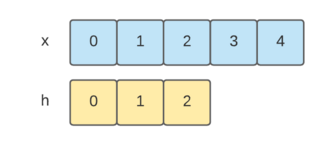

```
y[0] = h[0]*x[1]+h[1]*x[0]           = 0
y[1] = h[0]*x[2]+h[1]*x[1]*h[2]*x[0] = 1
y[2] = h[0]*x[3]+h[1]*x[2]*h[2]*x[1] = 4
y[3] = h[0]*x[4]+h[1]*x[3]+h[2]*x[2] = 7
y[4] = h[1]*x[4]+h[2]*x[3]           = 10
```





For the above example, the `convolve_gpu`:
- reads `x[0]` and `x[4]`  from the global memory twice,
- reads `x[1]`, `x[2]` and `x[3]` three times.

In general, we will get into the situtation where multiple threads read the same data from the global memory many times:




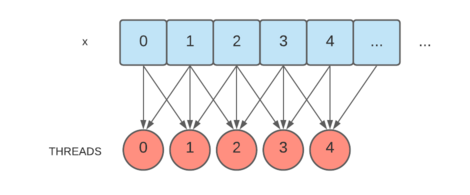

Is there any possibility to implement a GPU kernel that reads the above data from global memory only once?

## 2.2. Shared memory

The answer to the previous question is yes: using shared memory.

According to the [CUDA Toolkit documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html):
> (..) **shared memory** is expected to be a low-latency memory near each processor core (much like an L1 cache) (...)

>  **Shared memory** is expected to be much faster than global memory (...). It can be used as scratchpad memory (or software managed cache) to minimize global memory accesses from a CUDA block.

Shared memory has the following properties:
- the access time to the shared memory is much shorter than the access time to the global memory,
- it is usually much smaller than the global memory (the size of shared memory is usually counted in kilobytes, global memory -- in gigabytes),
- it's accessible only by CUDA kernel (i.e. it's not possible to write to / read from it directly from the host PC),
- its content is local for each thread block, i.e. for each block of threads, there is a separate area of shared memory.


You can check the amount of shared memory available for each thread block on your GPU by looking into device properties:

In [ ]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Shared memory per thread block: {device_props['sharedMemPerBlock']} [bytes]")

### 2.2.1. Tiling

A typical CUDA shared memory usage pattern is as follows:


- for each thread $i$ in a block:

  1. read data from the global to shared memory,
  2. wait until all threads in the block finish 1.,
  3. perform calculations using data available in the shared memory.


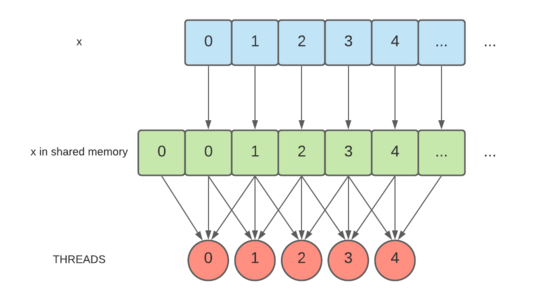

We can apply the above pattern to the `convolve_gpu_kernel` implementation:

- let's declare that each block has shared memory for $B+N-1$ samples,
  - where: $B$ is the size of the threads block, $N$ is the length of the filter, 
- for each thread $i$ in a block:

  1. read a portion of data from global to shared memory,
    - start with $k = i+o-(N-1)$,

    - read from global to shared memory: $x[k]$, $x[k+B]$, ..., and so on, until you hit the end of the shared memory area,
    - if $k + jB < 0$ or $k+jB \ge m$ for any $j$, write 0 to shared memory at position $i+jB$, otherwise write $x[k+jB]$,
  2. wait until all threads in the block finish 1.,
  3. compute $y[i]$.

Let's try the above strategy with our toy convolution example. Assume that $B = 5$.

```
x = [0, 1, 2, 3, 4]
h = [0, 1, 2]
shared_memory = [0, 0, 0, 0, 0, 0, 0]
```
(note: an unintialized shared memory may contain any arbitrary values, we used zeros just for clarity).


Some remarks: 

- We have a one block, that computes all the output samples.
- $N = 3$
- $o = 1$



**Step 1. Read a portion of data from global memory to shared memory.**

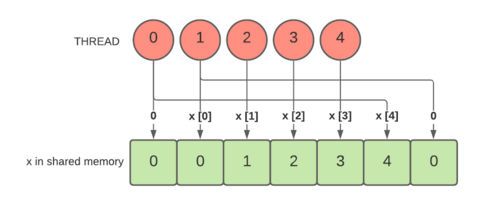



Thread $i=0$:
```
0. start with k = 0 + 1 - (3-1) = -1
1. k     =-1; i     = 0  => shared_memory[0] <- 0
2. k + B = 4; i + B = 5  => shared_memory[5] <- x[4]
3.            i + 2B = 10 => STOP
```

Thread $i=1$:
```
0. start with k = 0
1. k     = 0; i     = 1  => shared_memory[1] <- x[0],
2. k + B = 5; i + B = 6  => shared_memory[6] <- 0, 
3.            i + 2B = 11 => STOP, 
```

Thread $i=2$:
```
0. start with k = 1
1. k     = 1; i     = 2 => shared_memory[2] <- x[1],
2.            i + B = 7 => STOP, 
```


Thread $i=3$:
```
0. start with k = 2
1. k     = 2; i     = 3 => shared_memory[3] <- x[2],
2. k + B = 7; i + B = 8 => STOP, 
```

Thread $i=4$:
```
0. start with k = 3
1. k     = 3; i     = 4 => shared_memory[4] <- x[3],
2. k + B = 8; i + B = 9 => STOP, 
```

**Step 2. Wait until threads finish the above procedure**.

At this point:

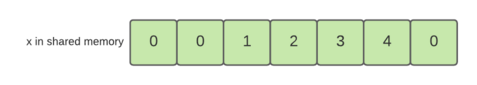

**Step 3. Compute $y$** 


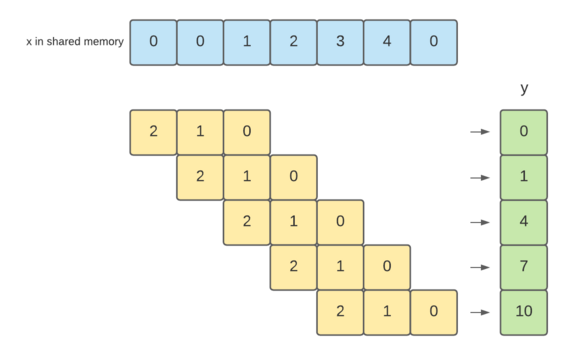

Each `x[i]` was read exactly once.

### 2.2.2. CUDA C and CuPy syntax for tiling

CUDA provides the following syntax for the shared memory area access:
- to use shared memory in CUDA C/C++ kernel, declare an `extern` variable with keyword `__shared__`,
- you can write to/read data from the shared memory area within GPU kernel code just like any other pointer in C language,
- to *wait until all threads in the block finish their job* use `__syncthreads()` function in CUDA C kernel.

When declare in the CUDA C kernel that you will use shared memory area, please remember to pass the shared memory size, which you will need for your calculations, as a kernel invocation parameter `shared_mem`:

```
kernel_object(grid, block, args, shared_mem)
```

(see also shared memory documentation available [here](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#shared-memory))

Let's implement the 1D convolution algorithm with shared memory.

**Exercise**

1. Open `2_2_convolve1d_shared_memory.cc` file.
2. Fill in the missing lines of code, marked with the `// TODO` comment.

In [ ]:
%%writefile 2_2_convolve_shared_memory.py
import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

convolve_gpu_kernel_src = open("2_2_convolve1d_shared_memory.cc").read()
convolve_gpu_kernel = cp.RawKernel(code=convolve_gpu_kernel_src, name="convolve1d")

def convolve_gpu(x, h):
    # Prepare input arguments.
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)

    # 1. DEFINE HIERARCHY OF THREADS. 
    block_size = 256
    grid_size = int(math.ceil(m/block_size))
    block = (block_size, )
    grid = (grid_size, )

    # 2. DETERMINE HOW MUCH SHARED MEMORY WE NEED
    shared_mem_size = block_size+n-1                          # Number of elements in shared memory.
    shared_mem_size_bytes = shared_mem_size*y.dtype.itemsize  # Number of bytes.
    
    # Make sure we are not exceeding the available shared memory size:
    device_props = cp.cuda.runtime.getDeviceProperties(0)
    if shared_mem_size_bytes > device_props['sharedMemPerBlock']:    
        raise ValueError("Declared shared memory size exceeds the amount available for the device.")

    # 3. INVOKE THE KERNEL.
    convolve_gpu_kernel(grid, block, args=(y, x, h, m, n, o, shared_mem_size), shared_mem=shared_mem_size_bytes)
    return y.get()

gpu_short_course.tests.run_convolve(convolve_gpu)

Let's test the implementation first:


In [ ]:
! python 2_2_convolve_shared_memory.py --mode test

In [ ]:
! nvprof --trace gpu python 2_2_convolve_shared_memory.py --mode benchmark n=10

Compare the above result with that of a convolution from section 2.1.2.

##  2.3. Constant memory

In our GPU convolution implementation, there is still one more array located in the global memory area whose values are read over and over again -- the filter $h$ cofficients.

The filter coefficients, like the input samples, could be pre-read by each thread block to shared memory, similar to what we did with the input signal $x$ -- we leave the implementation of this to the student as homework. 

In this exercise, we will use another type of memory to store the filter coefficients: i.e., constant memory.

According to the [CUDA Toolkit documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html):

> (...) The constant memory space resides in device memory and is cached in the constant cache. (...)

> Constants are immutable and may not be modified from the device, even between parent and child launches. That is to say, the value of all __constant__ variables must be set from the host prior to launch. Constant memory is inherited automatically by all child kernels from their respective parents.

> An SM has:
a read-only constant cache that is shared by all functional units and speeds up reads from the constant memory space, which resides in device memory (...)

Constant memory has the following properties:
- it resides in global memory, and is accessed by a Multiprocessor via *constant cache*, therefore reading from constant memory usually costs the time required to access low-latency cache memory, and usually is much faster than accessing global memory,
-  is read-only,
- due to the limited size of constant cache, the available *constant memory* space is much smaller than the available global memory,
- it can be accesed by a CUDA kernel,
- it can be initialized by host code.


Let's check the amout of constant memory available on our GPU:

In [ ]:
device_props = cp.cuda.runtime.getDeviceProperties(0)

print(f"Device name: {device_props['name']}")
print(f"Constant memory size: {device_props['totalConstMem']} [bytes]")

### 2.3.1. CUDA C and CuPy syntax for constant memory

To use constant memory in CuPy:
- in CUDA source code declare a global variable (e.g. an array) with `__constant__` keyword - this will be our pointer to constant memory,
- you can use the constant memory pointer in CUDA code as any other variable,
- create `cupy.RawModule` class to build kernels in CuPy (do not use `cupy.RawKernel`),
- to get a handle to kernel function: use method `.get_function` on the created `RawModule`, 
- to get a handle to CUDA constant symbol: use method `.get_global` on the created `RawModule`,
- wrap the handle to constant symbol into a cupy array, pass the handle to memptr argument of `cupy.ndarray` type,
- fill the const ndarray with data.

**Exercise**

1. Open `2_3_convolve1d_shared_const_memory.cc` file.
2. Update lines of code marked with the `// TODO` comment.

In [ ]:
%%writefile 2_3_convolve_const_memory.py
import math
import sys
import numpy as np
import cupy as cp
import gpu_short_course.tests

convolve_gpu_kernel_src = open("2_3_convolve1d_shared_const_memory.cc").read()

convolve_gpu_module = cp.RawModule(code=convolve_gpu_kernel_src)
device_props = cp.cuda.runtime.getDeviceProperties(0)

# Get a handle to the `convolve1d` function.
convolve_gpu_kernel = convolve_gpu_module.get_function("convolve1d")

# Get a handle to the constant variable `h`.
# First, determine the size of the filter we want to use.
# For testing purpose, we will use a filter with 5 coefficients.
# For benchmarking, we will use a filter with 256 coefficients.
mode = sys.argv[2]
if mode == "test":
    filter_size = 5
elif mode == "benchmark":
    filter_size = 256

if filter_size*4 > device_props["totalConstMem"]:
    # times 4, because we using 32-bit float type.
    raise ValueError("We are exceeding available constant memory size!")

# Make sure we are not exceeding available const memory area.
# Get a C pointer to the constant variable h.
h_ptr = convolve_gpu_module.get_global("h")
# Create the `h` array.
h = cp.ndarray(shape=(filter_size,), dtype=cp.float32, memptr=h_ptr)
h_host = np.random.rand(filter_size).astype(np.float32)
# Copy filter coefficients from host to GPU.
h.set(h_host)

def convolve_gpu(x):
    # Prepare input arguments.
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    m = len(x)
    n = len(h)
    o = int(math.ceil(n/2)-1)

    # 1. DEFINE HIERARCHY OF THREADS. 
    block_size = 256
    grid_size = int(math.ceil(m/block_size))
    block = (block_size, )
    grid = (grid_size, )

    # 2. DETERMINE HOW MUCH SHARED MEMORY WE NEED
    shared_mem_size = block_size+n-1                          # Number of elements in shared memory.
    shared_mem_size_bytes = shared_mem_size*y.dtype.itemsize  # Number of bytes.
    # Make sure we are not exceeding the available shared memory size:
    if shared_mem_size_bytes > device_props['sharedMemPerBlock']:    
        raise ValueError("We are exceeding available shared memory size!")
    # 3. INVOKE THE KERNEL.
    convolve_gpu_kernel(grid, block, args=(y, x, m, n, o, shared_mem_size), shared_mem=shared_mem_size_bytes)
    return y.get()

gpu_short_course.tests.run_convolve_const(convolve_gpu, h=h_host)

In [ ]:
! python 2_3_convolve_const_memory.py --mode test

In [ ]:
! nvprof --trace gpu python 2_3_convolve_const_memory.py --mode benchmark

## 2.4. Implementing image reconstruction in CUDA

We will now try to implement a simple ultrasonic signal beamformer for a sequence of transmissions of several **plane waves**. In our experiments we will use sample data generated in [Field 2](https://field-ii.dk/) simulation software.

We will implement B-mode image reconstruction based on RF data. The data can downloaded using the following instruction:  

In [ ]:
! wget -nc -O pwi_field2_sample_data.pkl "https://www.dropbox.com/s/n0ut1ncmfrlqy0t/pwi_field2_sample_data.pkl?dl=1"

And let's import all the necessary Python packages:

In [ ]:
import matplotlib.pyplot as plt
import scipy.signal
import math
import cupy as cp
import numpy as np
import itertools
import pickle

### 2.4.1. Data analysis

Now we will take a closer look at the RF data we have available in this course.

We can read the input data using `pickle` Python package. Let's do it now. 

In [ ]:
file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
list(file.keys())

The file contains two fields: `rf` and `context`.

The `context` contains all all the parameters that describe how the data were acquired (i.e. RF *metadata*), and which we will need in our RX beamforming code. Here we list available information:

In [ ]:
context = file["context"]
context

where:
- frequency values are in [Hz]
- speed is in [m/s]
- distance (e.g. probe's pitch) is in [m]
- angle is in [rad]

The `rf` field is a `numpy.ndarray` with signal data:

In [ ]:
rfs = file["rf"]
# Dimensions: 
n_sequences, n_txs, n_channels, n_samples = rfs.shape 

We will use a collection of RF sequences, which can be reconstructed to a sequence of B-mode images. Here are some example RF frames and scanlines:

In [ ]:
plt.figure(figsize=(15, 5))
plt.ylabel("Amplitude (a.u.)")
plt.xlabel("time ($\mu$s)")
start_sample = 2000
plt.plot(np.arange(start_sample, n_samples)/context["sampling_frequency"], rfs[0, 0, 63, start_sample:])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((7, 7))
ax.imshow(rfs[0, 0, :, start_sample:].T, vmin=-5e-11, vmax=5e-11)
ax.set_ylabel("Acquisiton depth ($\mu$s)")
ax.set_xlabel("Azimuth")
ax.set_aspect("auto")

### 2.4.2. PWI reconstruction on CPU

In these exercises, we will focus on implementing a beamformer for the **plane wave TX/RX sequence**.

**Input**:  

$S$: RF frame with dimensions: $(n_{tx}, n_{rx}, n_s)$

**Output**: 

$y$: beamformed frame with dimensions $(n_{x}, n_{z})$

\begin{equation*}
y[x, z] = \sum_{i=0}^{n_{tx}} \sum_{j=0}^{n_{rx}} S[i, j, \delta(x, z, p(j), \alpha(i))] 
\end{equation*}

where:
- $p(j)$ is the position of probe element $j$ (along OX, i.e. azimuth), 
- $\alpha(i)$ is an angle in transmit $i$,
- $\delta(x, z, p, a)$ is a receive delay (in number of samples). For plane wave imaging:

\begin{equation*}
\delta_{tx}(x, z, a) = zcos(a) + xsin(a)
\end{equation*}

\begin{equation*}
\delta_{rx}(x, z, p) = \sqrt{(x-p)^2 + z^2}
\end{equation*}

\begin{equation*}
\delta(x, z, p, a) = (\delta_{tx}(x, z, a) + \delta_{rx}(x, z, p))\frac{f_s}{c}
\end{equation*}

where $c$ is speed of sound and $f_s$ is a sampling frequency.

We assume that the origin of the coordinate system is located in the center of the probe aperture.

For the sake of simplicity:
- we do all calculations in time domain (i.e. we do not use IQ data here),
- we assume we use linear array probe, and probe elements are evenly spaced,
- we ommit RX apodization in our implementation,
- we use nearest-neighbour interpolation when determing input signal sample value.

All the above limitations are there to improve the clarity of the code presented in this notebook. This can be treated as a starting point for more advanced implementations.

As we did before, we will start with implementing the beamformer prototype for CPU.

First we will prepare a couple of auxiliary arrays which we will use in our implementation:
- probe element position:

In [ ]:
# distance between the leftmost and rightmost element of probe (centers)
probe_width = (n_channels-1) * context["pitch"]
# Position of each probe element (OX).
elements_x = np.linspace(-probe_width/2, probe_width/2, n_channels)

- output image grid points:

In [ ]:
nx, nz = 128, 128
grid_x = np.linspace(-15, 15, nx)*1e-3  # OX coordinates (meters)
grid_z = np.linspace( 20, 50, nz)*1e-3  # OZ coordinates (m)
grid_extent = [np.min(grid_x), np.max(grid_x), np.max(grid_z), np.min(grid_z)]

**Exercise**

Fill in the missing line(s) of code, marked with the `# TODO` comment.

In [ ]:
def beamform(S, grid_x, grid_z, context):
    n_transmits, n_channels, n_samples = S.shape
    nx = len(grid_x)
    nz = len(grid_z)
    
    angles             = context["angles"]
    speed_of_sound     = context["speed_of_sound"]
    sampling_frequency = context["sampling_frequency"]
    y = np.zeros((nx, nz), dtype=np.float32)
    
    grid_x = enumerate(grid_x)  # pairs (ix, x), where ix is the index of x in the list
    grid_z = enumerate(grid_z)  # pairs (iz, z), where iz is the index of z in the list
    
    for (ix, x), (iz, z) in itertools.product(grid_x, grid_z):
        pixel_value = 0.0
        for i, angle in enumerate(angles):
            tx_distance = # TODO
            for j in range(n_channels):
                rx_distance = # TODO
                propagation_time = (tx_distance+rx_distance)/speed_of_sound;
                sample_number = propagation_time*sampling_frequency;
                sample_number = int(round(sample_number))
                if sample_number >= 0 and sample_number < n_samples:
                    pixel_value += S[i, j, sample_number]
        y[ix, iz] = pixel_value 
    return y

Now, let's inspect our implementation. For now, we will use the following post-processing CPU implementation:

In [ ]:
def to_bmode_cpu(rf_beamformed):
    envelope = np.abs(scipy.signal.hilbert(rf_beamformed, axis=0))
    res = 20*np.log10(envelope/np.max(envelope))
    return res

Here we present the first reconstructed image.

In [ ]:
y = beamform(rfs[10], grid_x, grid_z, context)
plt.imshow(to_bmode_cpu(y).T, cmap="gray", vmin=-30, vmax=0)

Let's we check how much time our reconstruction code takes:

In [ ]:
%time y = beamform(rfs[10], grid_x, grid_z, context)

### 2.4.3. PWI reconstruction on GPU

In this part of the notebook, we will implement a GPU beamformer. 

Just like before, first we will consider how can we divide data beamforming into smaller subtasks, preferably in such a way that all subtasks are independent of each other. 

Note that, as in the previous examples, output image **pixels** can be calculated independently of each other. That is, for each **output pixel** we can assign a  separate **CUDA thread** that will be responsible for calculating the sum of amplitudes, measured at physical location of that pixel.

Let's try now implementing the `beamform` function for GPU devices.

This time we will wrap the beamformer code into a class that will keep references to GPU resources that we need in the image reconstruction. In the class constructor (function `__init__`) we will initialize GPU data, which is constant during the beamformer operation and does not depend on the RF frames we receive in run-time. This includes e.g. probe the `elements_x` and `angles` arrays. The second, `process` function will be responsible for doing the reconstruction on GPU, in accordance with the assumptions we have made above.

**Exercise**

1. Open `2_4_beamform.cc` file.
2. Update lines of code marked with the `// TODO` comment.

In [ ]:
class Beamformer:
    
    def __init__(self, grid_x, grid_z, elements_x, context):
        # Create beamforming GPU kernel.
        beamform_src = open("2_4_beamform.cc").read()
        self.beamform_kernel = cp.RawKernel(code=beamform_src, name="beamform")
        # Hierarchy of threads.
        self.block = (16, 16)
        self.nx, self.nz = len(grid_x), len(grid_z)
        self.grid = (int(math.ceil(nz/self.block[0])), int(math.ceil(nx/self.block[1])))
        # All other parameters to GPU.
        self.grid_x_gpu = cp.asarray(grid_x, dtype=cp.float32)
        self.grid_z_gpu = cp.asarray(grid_z, dtype=cp.float32)
        self.elements_x_gpu = cp.asarray(elements_x, dtype=cp.float32)
        self.angles_gpu = cp.asarray(context["angles"], dtype=cp.float32)
        # NOTE: we have to use the below lines of code to make sure, that the input parameters
        # are 32-bit floating points. 
        self.speed_of_sound = cp.float32(context["speed_of_sound"])
        self.sampling_frequency = cp.float32(context["sampling_frequency"])
        # Output array.
        self.output = cp.zeros((nx, nz), dtype=cp.float32)
        
    def process(self, rf):
        rf_gpu = cp.asarray(rf, dtype=cp.float32)
        n_transmits, n_elements, n_samples = rf_gpu.shape
        self.beamform_kernel(self.grid, self.block, 
            args=(
                self.output, rf_gpu,
                self.grid_z_gpu,      self.nz,
                self.grid_x_gpu,      self.nx,
                self.angles_gpu,      n_transmits,
                self.elements_x_gpu,  n_elements,
                n_samples, 
                self.speed_of_sound, self.sampling_frequency))
        return self.output.get()

Now let's check our implementation. Here we generate a sequence of B-mode images for our RF data. To display the sequence of B-mode frames, in the code below we use `show_cineloop` function, which is available in the `gpu_short_course.ultrasound_imaging` package. Then, we convert the generated `Animation` object into a form that can be displayed in Jupyter notebook.

In [ ]:
from IPython.display import HTML
from gpu_short_course.ultrasound_imaging import show_cineloop

bmodes = []
beamformer = Beamformer(grid_x, grid_z, elements_x, context)

for rf in rfs:
    output = beamformer.process(rf)
    bmode = to_bmode_cpu(output)
    bmodes.append(bmode.T)
    
anim = show_cineloop(bmodes, cmap="gray", value_range=(-30, 0), extent=grid_extent, figsize=(4, 4))
plt.close()
HTML(anim.to_jshtml())

Now, we will use a profiler to verify how much time the `beamform` GPU kernel takes.

The below script:
- loads the input data,
- creates `Beamformer` class, which is the same class we have used above,
- reconstructs images using `Beamformer`'s GPU kernel and converts them to B-mode images,
- saves the generated sequence of B-modes as an animation to a gif file.

In [ ]:
%%writefile 2_4_beamform.py

import math
import pickle
import cupy as cp
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (
    show_cineloop, to_bmode_cpu
)


file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
list(file.keys())

rfs = file["rf"]
context = file["context"]
n_sequences, n_transmits, n_channels, n_samples = rfs.shape

probe_width = (n_channels-1) * context["pitch"]
elements_x = np.linspace(-probe_width/2, probe_width/2, n_channels).astype(np.float32)

nx, nz = 128, 128
grid_x = np.linspace(-15, 15, nx)*1e-3  # OX coordinates (meters)
grid_z = np.linspace( 20, 50, nz)*1e-3  # OZ coordinates (m)
grid_extent = [np.min(grid_x), np.max(grid_x), np.max(grid_z), np.min(grid_z)]

class Beamformer:
    
    def __init__(self, grid_x, grid_z, elements_x, context):
        # Create beamforming GPU kernel.
        beamform_src = open("2_4_beamform.cc").read()
        self.beamform_kernel = cp.RawKernel(code=beamform_src, name="beamform")
        # Hierarchy of threads.
        self.block = (16, 16)
        self.nx, self.nz = len(grid_x), len(grid_z)
        self.grid = (int(math.ceil(nz/self.block[0])), int(math.ceil(nx/self.block[1])))
        # All other parameters to GPU.
        self.grid_x_gpu = cp.asarray(grid_x, dtype=cp.float32)
        self.grid_z_gpu = cp.asarray(grid_z, dtype=cp.float32)
        self.elements_x_gpu = cp.asarray(elements_x, dtype=cp.float32)
        self.angles_gpu = cp.asarray(context["angles"], dtype=cp.float32)
        # NOTE: we have to use the below lines of code to make sure, that the input parameters
        # are 32-bit floating points. 
        self.speed_of_sound = cp.float32(context["speed_of_sound"])
        self.sampling_frequency = cp.float32(context["sampling_frequency"])
        # Output array.
        self.output = cp.zeros((nx, nz), dtype=cp.float32)
        
    def process(self, rf):
        rf_gpu = cp.asarray(rf, dtype=cp.float32)
        n_transmits, n_elements, n_samples = rf_gpu.shape
        self.beamform_kernel(self.grid, self.block, 
            args=(
                self.output, rf_gpu,
                self.grid_z_gpu,      self.nz,
                self.grid_x_gpu,      self.nx,
                self.angles_gpu,      n_transmits,
                self.elements_x_gpu,  n_elements,
                n_samples, 
                self.speed_of_sound, self.sampling_frequency))
        return self.output.get()
    

bmodes = []
beamformer = Beamformer(grid_x, grid_z, elements_x, context)

for rf in rfs:
    output = beamformer.process(rf)
    bmode = to_bmode_cpu(output)
    bmodes.append(bmode.T)
    
anim = show_cineloop(bmodes, cmap="gray", value_range=(-30, 0), extent=grid_extent, figsize=(4, 4))
anim.save('2_4_beamformer_output.gif', writer='imagemagick', fps=30)

In [ ]:
! nvprof --trace gpu python 2_4_beamform.py

You can now open `2_4_beamform_output.gif` file to be sure that we get correct results.

### 2.4.4. Using constant memory in beamformer

As you've probably noticed, parameters such as the position of the head elements are the same for all the RF frames we load. The idea immediately arises that since these parameters are constant during frame-by-frame processing, it may be worth putting them in the GPU constant memory. We will also do this in the code below.

Let's try moving `elements_x` and `angles` to const GPU memory and see if it give us any improvement. First, we need to update our GPU kernel so it uses const arrays instead of the provided parameters.

**Exercise**

1. Open `2_4_beamform_const.cc` file.
2. Update lines of code marked with the `// TODO` comment.

And here is the updated Python script that runs the const version of our GPU kernel. The changes we have made here:
- `self.elements_x_gpu` and `self.angles_gpu` now are created using `create_const_array` function, which simply get's the pointer to given const field, wraps the pointer into a `cupy` array and  transfers host data to it,
- we have removed `elements_x_gpu` and `angles_gpu` parameters from the kernel arguments list, as they as they are no longer needed.

In [ ]:
%%writefile 2_4_beamform_const.py

import math
import pickle
import cupy as cp
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from gpu_short_course.ultrasound_imaging import (
    show_cineloop, to_bmode_cpu
)

file = pickle.load(open("pwi_field2_sample_data.pkl", "rb"))
list(file.keys())

rfs = file["rf"]
context = file["context"]
n_sequences, n_transmits, n_channels, n_samples = rfs.shape

probe_width = (n_channels-1) * context["pitch"]
elements_x = np.linspace(-probe_width/2, probe_width/2, n_channels).astype(np.float32)

nx, nz = 128, 128
grid_x = np.linspace(-15, 15, nx)*1e-3  # OX coordinates (meters)
grid_z = np.linspace( 20, 50, nz)*1e-3  # OZ coordinates (m)
grid_extent = [np.min(grid_x), np.max(grid_x), np.max(grid_z), np.min(grid_z)]

device_props = cp.cuda.runtime.getDeviceProperties(0)


class Beamformer:
    
    def __init__(self, grid_x, grid_z, elements_x, context):
        beamform_src = open("2_4_beamform_const.cc").read()
        self.beamform_module = cp.RawModule(code=beamform_src)
        self.beamform_kernel = self.beamform_module.get_function("beamform")
        self.block = (16, 16)
        self.nx, self.nz = len(grid_x), len(grid_z)
        self.grid = (int(math.ceil(nz/self.block[0])), int(math.ceil(nx/self.block[1])))
        self.grid_x_gpu = cp.asarray(grid_x, dtype=cp.float32)
        self.grid_z_gpu = cp.asarray(grid_z, dtype=cp.float32)
        
        # Here is the const memory initialization.
        if device_props['totalConstMem'] < 512 * 4: # We have two arrays, each 256 of 4-byte floats 
            raise ValueError("We have not enough constant memory!")
        
        self.elements_x_gpu = self.create_const_array(elements_x, name="elements_x", dtype=cp.float32)
        self.angles_gpu     = self.create_const_array(context["angles"], name="angles", dtype=cp.float32)
        
        self.speed_of_sound = cp.float32(context["speed_of_sound"])
        self.sampling_frequency = cp.float32(context["sampling_frequency"])
        self.output = cp.zeros((nx, nz), dtype=cp.float32)
        
    def create_const_array(self, host_data, name, dtype):
        const_mem_ptr = self.beamform_module.get_global(name)
        gpu_data = cp.ndarray(shape=host_data.shape, dtype=dtype, memptr=const_mem_ptr)
        gpu_data.set(host_data)
        return gpu_data
        
    def process(self, rf):
        rf_gpu = cp.asarray(rf, dtype=cp.float32)
        n_transmits, n_elements, n_samples = rf_gpu.shape
        self.beamform_kernel(self.grid, self.block, 
            args=(
                self.output, rf_gpu,
                self.grid_z_gpu,      self.nz,
                self.grid_x_gpu,      self.nx,
                # Do not pass const arrays to GPU kernel, 
                # the kernel also already have an access to constant fileds as a global variable.
                n_transmits, n_elements, n_samples, 
                self.speed_of_sound, self.sampling_frequency))
        return self.output.get()
    

bmodes = []
beamformer = Beamformer(grid_x, grid_z, elements_x, context)

for rf in rfs:
    output = beamformer.process(rf)
    bmode = to_bmode_cpu(output)
    bmodes.append(bmode.T)
    
anim = show_cineloop(bmodes, cmap="gray", value_range=(-30, 0), extent=grid_extent, figsize=(4, 4))
anim.save('2_4_beamformer_const_output.gif', writer='imagemagick', fps=30)

In [ ]:
! nvprof --trace gpu python 2_4_beamform_const.py

You can now open `2_4_beamform_const_output.gif` file to be sure that we get correct results.

# References

- [CUDA Toolkit Documentation: Memory Hierarchy](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#memory-hierarchy)
- [CUDA Best Practices Guide: Shared Memory](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory)
- [CUDA Best Practices Guide: Constant Memory](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#constant-memory)